In [ ]:
cd /content/drive/Othercomputers/mypc/COURSEWORK/semester2/Forecasting/ForecastFrontiers/Online Retail

/content/drive/.shortcut-targets-by-id/1jtLfnNfNGi4cMEzvte9TTKpNYip6m9x6/ForecastFrontiers/Online Retail


In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import logging
from prophet.plot import plot_components_plotly
from sklearn.preprocessing import  StandardScaler
from sklearn.neighbors import KNeighborsClassifier

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Weekly Level

  ## Weekly Level without removing outliers

Start Parallel Grid Search...


100%|██████████| 3072/3072 [29:58<00:00,  1.71it/s]



Best Parameters Found:
changepoint_prior_scale        0.01
seasonality_prior_scale         1.0
holidays_prior_scale            1.0
seasonality_mode           additive
yearly_fourier                    6
weekly_fourier                   10
monthly_fourier                  10
use_holidays                  False
add_weekly                     True
add_monthly                   False
mape                       0.202104
Name: 1213, dtype: object

Final Test MAPE: 10.65 %


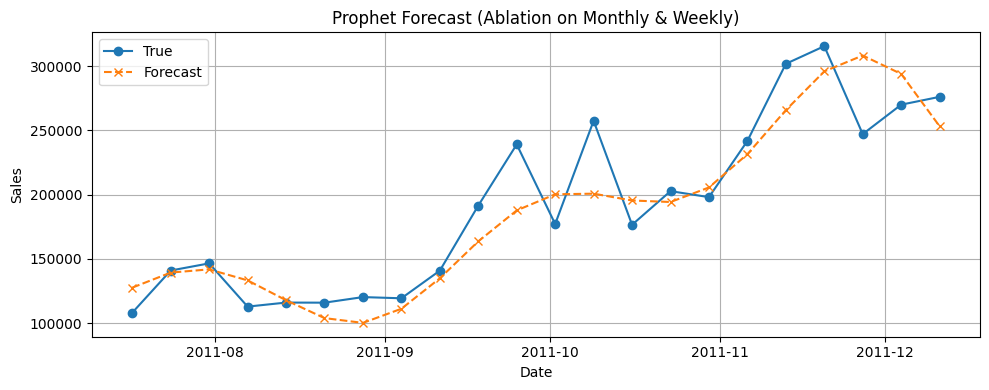

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
import itertools
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Step 0: Load and preprocess data
df = pd.read_csv("cleaned_retail_dataset.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df_all = df.copy()
df_all = df_all.set_index('InvoiceDate')
total_sales = df_all['Sales'].resample('D').sum().reset_index()
total_sales.columns = ['ds', 'y']
total_sales['ds'] = pd.to_datetime(total_sales['ds'])
total_sales['y'] = total_sales['y'].astype(float)

# Resample to Weekly
weekly_sales = total_sales.set_index('ds').resample('W').sum().reset_index()

# Step 1: Prepare data
weekly_sales = weekly_sales.sort_values(by='ds').reset_index(drop=True)
n = len(weekly_sales)
n_train = int(n * 0.6)
n_val = int(n * 0.2)

train_df = weekly_sales.iloc[:n_train].copy()
val_df = weekly_sales.iloc[n_train:n_train + n_val].copy()
test_df = weekly_sales.iloc[n_train + n_val:].copy()

# Step 2: UK Holidays
min_year = pd.to_datetime(weekly_sales['ds']).dt.year.min()
max_year = pd.to_datetime(weekly_sales['ds']).dt.year.max()
uk_holidays = make_holidays_df(year_list=list(range(min_year, max_year + 1)), country='UK')

# Step 3: Parameter Grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1],
    'seasonality_prior_scale': [0.1, 1.0],
    'holidays_prior_scale': [0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_fourier': [5, 6, 7, 8, 9, 10],
    'weekly_fourier': [5,10] ,
    'monthly_fourier': [5,10],
    'use_holidays': [True, False],
    'add_weekly': [True, False],
    'add_monthly': [True, False],
}

grid_keys = list(param_grid.keys())
all_params = [dict(zip(grid_keys, v)) for v in itertools.product(*param_grid.values())]

# Step 4: Define parallel training function
def run_one_config(params):
    try:
        if params['use_holidays']:
            m = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                seasonality_mode=params['seasonality_mode'],
                holidays=uk_holidays
            )
        else:
            m = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                seasonality_mode=params['seasonality_mode']
            )


        m.add_seasonality(name='yearly', period=365.25, fourier_order=params['yearly_fourier'])
        if params['add_weekly']:
            m.add_seasonality(name='weekly', period=7, fourier_order=params['weekly_fourier'])
        if params['add_monthly']:
            m.add_seasonality(name='monthly', period=30.5, fourier_order=params['monthly_fourier'])

        m.fit(train_df)
        forecast_val = m.predict(val_df[['ds']])

        y_true = val_df['y'].values
        y_pred = forecast_val['yhat'].values
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5)))

        result = {**params, 'mape': mape}
        return result

    except Exception as e:
        print(f"Error with params {params}: {e}")
        return None

# Step 5: Parallel Grid Search
print("Start Parallel Grid Search...")
with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(tqdm(executor.map(run_one_config, all_params), total=len(all_params)))
results = [r for r in results if r is not None]

# Step 6: Analyze Results
tuning_results = pd.DataFrame(results)
best_params = tuning_results.sort_values(by='mape').iloc[0]
print("\nBest Parameters Found:")
print(best_params)

# Step 7: Retrain final model on train+val
combined_df = pd.concat([train_df, val_df]).reset_index(drop=True)

if best_params['use_holidays']:
    final_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        holidays_prior_scale=best_params['holidays_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        holidays=uk_holidays
    )
else:
    final_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        holidays_prior_scale=best_params['holidays_prior_scale'],
        seasonality_mode=best_params['seasonality_mode']
    )

final_model.add_seasonality(name='yearly', period=365.25, fourier_order=best_params['yearly_fourier'])
if best_params['add_weekly']:
    final_model.add_seasonality(name='weekly', period=7, fourier_order=best_params['weekly_fourier'])
if best_params['add_monthly']:
    final_model.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['monthly_fourier'])

final_model.fit(combined_df)

# Step 8: Predict on test set
future_test = test_df[['ds']].copy()
forecast_test = final_model.predict(future_test)

y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values
mape_test = np.mean(np.abs((y_true_test - y_pred_test) / (y_true_test + 1e-5)))
print(f"\nFinal Test MAPE: {round(mape_test * 100, 2)} %")

# Step 9: Plot forecast
plt.figure(figsize=(10, 4))
plt.plot(test_df['ds'], y_true_test, label="True", marker='o')
plt.plot(test_df['ds'], y_pred_test, label="Forecast", linestyle='--', marker='x')
plt.title('Prophet Forecast (Ablation on Monthly & Weekly)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plot_components_plotly(final_model, forecast_test)

Overall MAPE for Test Period 1: 9.49%
Overall MAPE for Test Period 2: 12.89%
Overall MAPE for Test Period 3: 9.73%


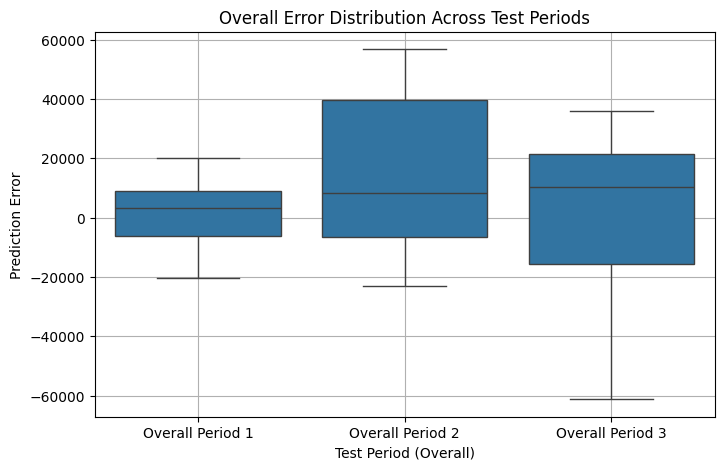

In [ ]:
import seaborn as sns
x = np.array_split(forecast_test.set_index("ds"),3)

error_df = []
for i, df_test in enumerate(x):
    period_error = (test_df.set_index('ds').loc[df_test.index,:].y - df_test.yhat)
    error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))
    m = mape(test_df.set_index('ds').loc[df_test.index,:].y,df_test.yhat )
    print(f"Overall MAPE for Test Period {i+1}: {m:.2f}%")
error_df = pd.concat(error_df)

plt.figure(figsize=(8,5))
sns.boxplot(x="Test Period", y="Error", data=error_df)
plt.title("Overall Error Distribution Across Test Periods")
plt.xlabel("Test Period (Overall)")
plt.ylabel("Prediction Error")
plt.grid()
plt.show()

## Weekly Level with removing outliers

In [ ]:
df = pd.read_csv("cleaned_retail_dataset.csv")
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df_all = df.copy()
df_all = df_all.set_index('InvoiceDate')
total_sales = df_all['Sales'].resample('D').sum().reset_index()
total_sales.columns = ['ds', 'y']
total_sales['ds'] = pd.to_datetime(total_sales['ds'])
total_sales['y'] = total_sales['y'].astype(float)

#Resample to Weekly
weekly_sales = total_sales.set_index('ds').resample('W').sum().reset_index()


Start Parallel Grid Search...


100%|██████████| 3072/3072 [32:24<00:00,  1.58it/s]



Best Parameters Found:
changepoint_prior_scale              0.01
seasonality_prior_scale               0.1
holidays_prior_scale                  0.1
seasonality_mode           multiplicative
yearly_fourier                          6
weekly_fourier                         10
monthly_fourier                        10
use_holidays                         True
add_weekly                          False
add_monthly                         False
mape                             0.176279
Name: 251, dtype: object

Final Test MAPE: 17.34 %


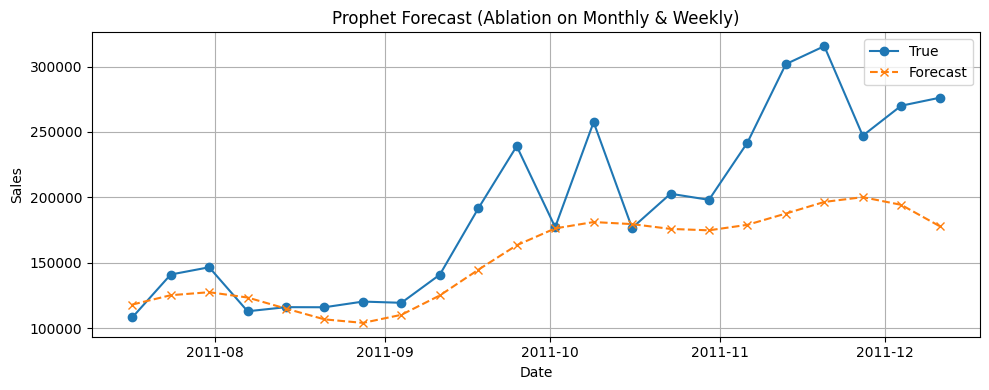

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
import itertools
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Step 0: Load and preprocess data
df = pd.read_csv("cleaned_retail_dataset.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df_all = df.copy()
df_all = df_all.set_index('InvoiceDate')
total_sales = df_all['Sales'].resample('D').sum().reset_index()
total_sales.columns = ['ds', 'y']
total_sales['ds'] = pd.to_datetime(total_sales['ds'])
total_sales['y'] = total_sales['y'].astype(float)

# Resample to Weekly
weekly_sales = total_sales.set_index('ds').resample('W').sum().reset_index()

# Step 1: Prepare data
weekly_sales = weekly_sales.sort_values(by='ds').reset_index(drop=True)
n = len(weekly_sales)
n_train = int(n * 0.6)
n_val = int(n * 0.2)

train_df = weekly_sales.iloc[:n_train].copy()
Q1 = train_df['y'].quantile(0.25)
Q3 = train_df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train_df = train_df[(train_df['y'] >= lower_bound) & (train_df['y'] <= upper_bound)]

val_df = weekly_sales.iloc[n_train:n_train + n_val].copy()
test_df = weekly_sales.iloc[n_train + n_val:].copy()

# Step 2: UK Holidays
min_year = pd.to_datetime(weekly_sales['ds']).dt.year.min()
max_year = pd.to_datetime(weekly_sales['ds']).dt.year.max()
uk_holidays = make_holidays_df(year_list=list(range(min_year, max_year + 1)), country='UK')

# Step 3: Parameter Grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1],
    'seasonality_prior_scale': [0.1, 1.0],
    'holidays_prior_scale': [0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_fourier': [5, 6, 7, 8, 9, 10],
    'weekly_fourier': [5,10] ,
    'monthly_fourier': [5,10],
    'use_holidays': [True, False],
    'add_weekly': [True, False],
    'add_monthly': [True, False],
}

grid_keys = list(param_grid.keys())
all_params = [dict(zip(grid_keys, v)) for v in itertools.product(*param_grid.values())]

# Step 4: Define parallel training function
def run_one_config(params):
    try:
        if params['use_holidays']:
            m = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                seasonality_mode=params['seasonality_mode'],
                holidays=uk_holidays
            )
        else:
            m = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                seasonality_mode=params['seasonality_mode']
            )


        m.add_seasonality(name='yearly', period=365.25, fourier_order=params['yearly_fourier'])
        if params['add_weekly']:
            m.add_seasonality(name='weekly', period=7, fourier_order=params['weekly_fourier'])
        if params['add_monthly']:
            m.add_seasonality(name='monthly', period=30.5, fourier_order=params['monthly_fourier'])

        m.fit(train_df)
        forecast_val = m.predict(val_df[['ds']])

        y_true = val_df['y'].values
        y_pred = forecast_val['yhat'].values
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5)))

        result = {**params, 'mape': mape}
        return result

    except Exception as e:
        print(f"Error with params {params}: {e}")
        return None

# Step 5: Parallel Grid Search
print("Start Parallel Grid Search...")
with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(tqdm(executor.map(run_one_config, all_params), total=len(all_params)))
results = [r for r in results if r is not None]

# Step 6: Analyze Results
tuning_results = pd.DataFrame(results)
best_params = tuning_results.sort_values(by='mape').iloc[0]
print("\nBest Parameters Found:")
print(best_params)

# Step 7: Retrain final model on train+val
combined_df = pd.concat([train_df, val_df]).reset_index(drop=True)

if best_params['use_holidays']:
    final_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        holidays_prior_scale=best_params['holidays_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        holidays=uk_holidays
    )
else:
    final_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        holidays_prior_scale=best_params['holidays_prior_scale'],
        seasonality_mode=best_params['seasonality_mode']
    )

final_model.add_seasonality(name='yearly', period=365.25, fourier_order=best_params['yearly_fourier'])
if best_params['add_weekly']:
    final_model.add_seasonality(name='weekly', period=7, fourier_order=best_params['weekly_fourier'])
if best_params['add_monthly']:
    final_model.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['monthly_fourier'])

final_model.fit(combined_df)

# Step 8: Predict on test set
future_test = test_df[['ds']].copy()
forecast_test = final_model.predict(future_test)

y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values
mape_test = np.mean(np.abs((y_true_test - y_pred_test) / (y_true_test + 1e-5)))
print(f"\nFinal Test MAPE: {round(mape_test * 100, 2)} %")

# Step 9: Plot forecast
plt.figure(figsize=(10, 4))
plt.plot(test_df['ds'], y_true_test, label="True", marker='o')
plt.plot(test_df['ds'], y_pred_test, label="Forecast", linestyle='--', marker='x')
plt.title('Prophet Forecast (Ablation on Monthly & Weekly)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plot_components_plotly(final_model, forecast_test)

Overall MAPE for Test Period 1: 9.11%
Overall MAPE for Test Period 2: 16.09%
Overall MAPE for Test Period 3: 28.00%


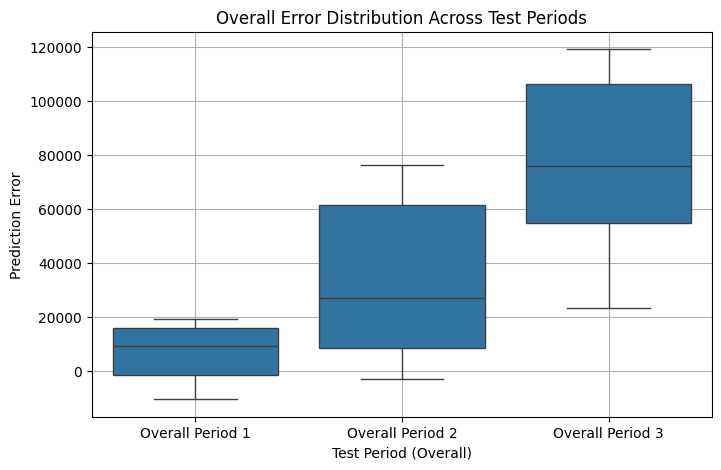

In [ ]:
import seaborn as sns
x = np.array_split(forecast_test.set_index("ds"),3)

error_df = []
for i, df_test in enumerate(x):
    period_error = (test_df.set_index('ds').loc[df_test.index,:].y - df_test.yhat)
    error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))
    m = mape(test_df.set_index('ds').loc[df_test.index,:].y,df_test.yhat )
    print(f"Overall MAPE for Test Period {i+1}: {m:.2f}%")
error_df = pd.concat(error_df)

plt.figure(figsize=(8,5))
sns.boxplot(x="Test Period", y="Error", data=error_df)
plt.title("Overall Error Distribution Across Test Periods")
plt.xlabel("Test Period (Overall)")
plt.ylabel("Prediction Error")
plt.grid()
plt.show()

# Clustering and weekly level

# Doing Clustering in Weekly level

## KMEANS 2



⏳ Tuning Prophet for Cluster 1


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


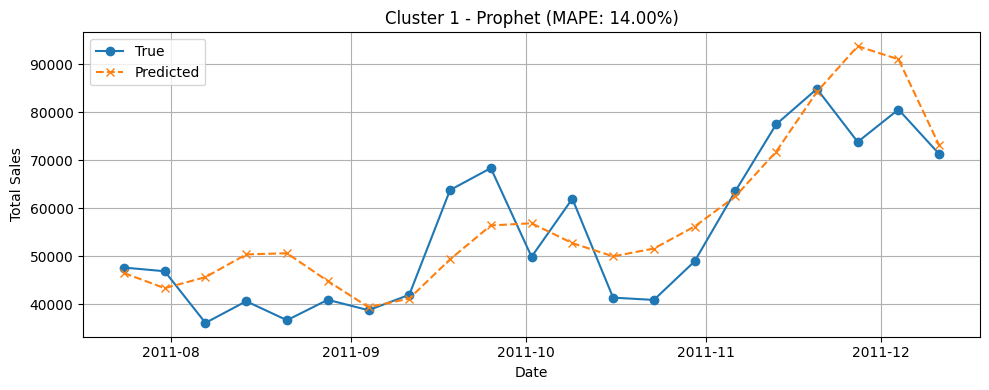


⏳ Tuning Prophet for Cluster 2


100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


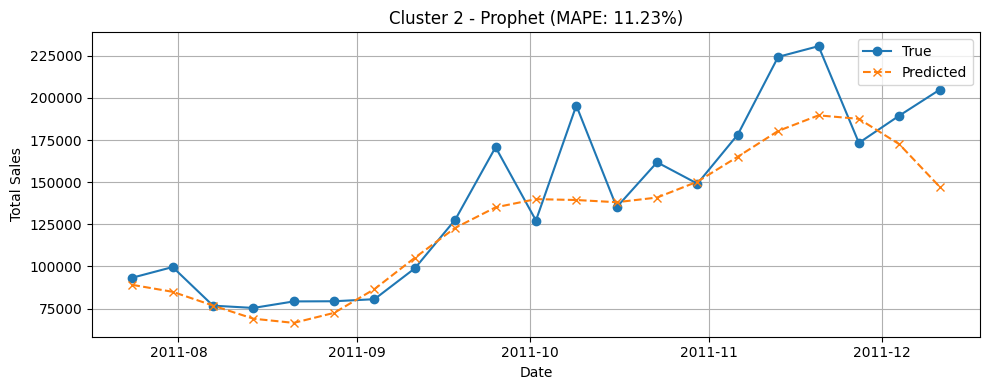


📊 Cluster-wise Forecasting MAPE (Prophet):
    MAPE (%)
0  14.000268
1  11.226323

🌍 Total MAPE (Prophet): 12.61%

✅ Best params for Cluster 1:
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_fourier': 10, 'weekly_fourier': 5, 'monthly_fourier': 5, 'use_holidays': True, 'add_weekly': False, 'add_monthly': False}

✅ Best params for Cluster 2:
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_fourier': 6, 'weekly_fourier': 5, 'monthly_fourier': 5, 'use_holidays': True, 'add_weekly': False, 'add_monthly': False}

🔍 Analyzing error for Cluster 1
Cluster 1 - Period 1 MAPE: 15.61%
Cluster 1 - Period 2 MAPE: 16.81%
Cluster 1 - Period 3 MAPE: 9.58%

🔍 Analyzing error for Cluster 2
Cluster 2 - Period 1 MAPE: 8.58%
Cluster 2 - Period 2 MAPE: 12.12%
Cluster 2 - Period 3 MAPE: 12.98%


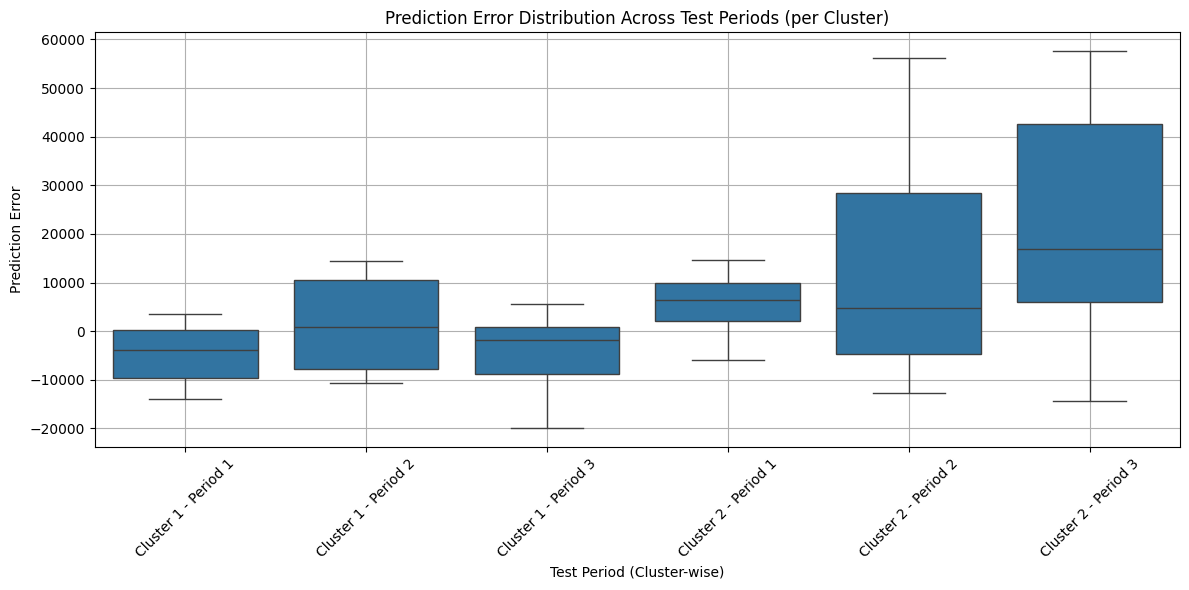


Drawing overall flattened forecast trend and test period error analysis...

Total MAPE (Prophet, Flattened): 12.61%


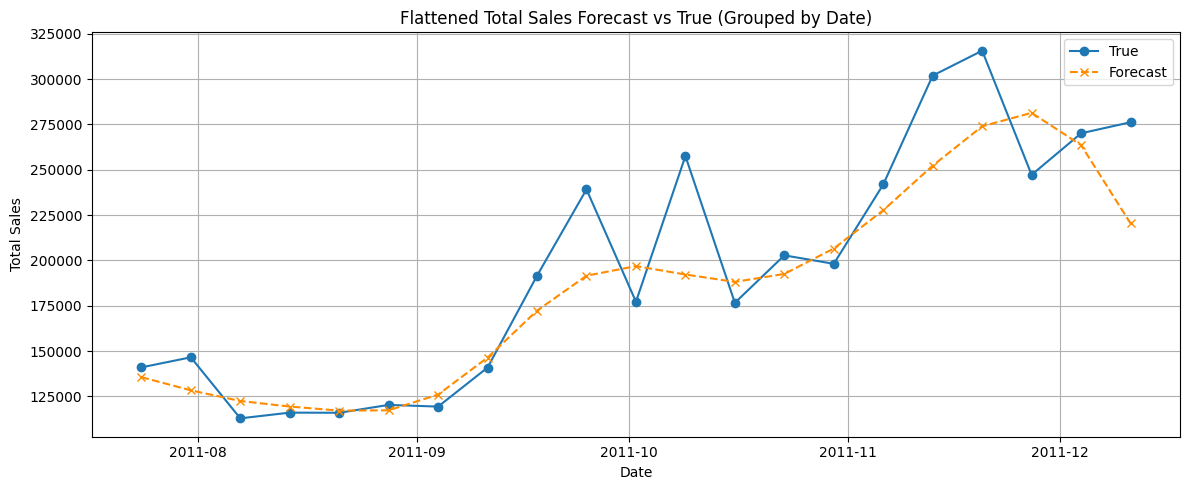

Period 1 MAPE: 12.10%
Period 2 MAPE: 14.46%
Period 3 MAPE: 11.28%


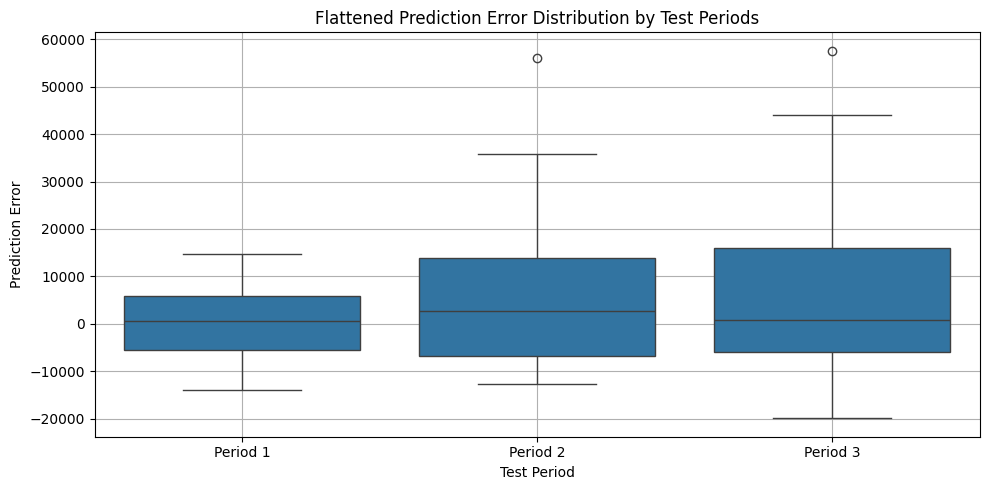

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import seaborn as sns
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

# Step 1: Load data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

product_clusters = pd.read_csv("Our Categorization/product_cluster_labels_k2.csv", index_col=0)

weekly_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 2: Train / test split
split_date = weekly_sales.index[int(len(weekly_sales) * 0.8)]
train_sales = weekly_sales.loc[:split_date]
test_sales = weekly_sales.loc[split_date:]

# Step 3: KNN for unknown products
known_products = product_clusters.index
unknown_products = [p for p in test_sales.columns if p not in known_products]

scaler = StandardScaler()
X_known = scaler.fit_transform(train_sales[known_products].T)
y_known = product_clusters.loc[known_products]["cluster"]

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_known, y_known)

if unknown_products:
    X_unknown = scaler.transform(test_sales[unknown_products].T)
    predicted_clusters = knn.predict(X_unknown)
    predicted_df = pd.DataFrame({"StockCode": unknown_products, "cluster": predicted_clusters}).set_index("StockCode")
    all_clusters = pd.concat([product_clusters, predicted_df])
else:
    all_clusters = product_clusters.copy()

# Step 4: Aggregate by cluster
train_cluster_series = train_sales.T.join(all_clusters).groupby("cluster").sum().T
test_cluster_series = test_sales.T.join(all_clusters).groupby("cluster").sum().T

# Step 5: Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1],
    'seasonality_prior_scale': [0.1, 1.0],
    'holidays_prior_scale': [0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_fourier': [5, 6, 7, 8, 9, 10],
    'weekly_fourier': [5,10],
    'monthly_fourier': [5,10],
    'use_holidays': [True, False],
    'add_weekly': [True, False],
    'add_monthly': [True, False],
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# UK holidays
min_year = df.index.min().year
max_year = df.index.max().year
uk_holidays = make_holidays_df(year_list=list(range(min_year, max_year + 1)), country='UK')

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

# Step 6: Tuning function per cluster
def tune_one_config(train_df, test_df, param_values):
    params = dict(zip(param_names, param_values))
    try:
        if params['use_holidays']:
            m = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                seasonality_mode=params['seasonality_mode'],
                holidays=uk_holidays
            )
        else:
            m = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                seasonality_mode=params['seasonality_mode']
            )

        m.add_seasonality(name='yearly', period=365.25, fourier_order=params['yearly_fourier'])
        if params['add_weekly']:
            m.add_seasonality(name='weekly', period=7, fourier_order=params['weekly_fourier'])
        if params['add_monthly']:
            m.add_seasonality(name='monthly', period=30.5, fourier_order=params['monthly_fourier'])

        m.fit(train_df)
        future = m.make_future_dataframe(periods=len(test_df), freq="W")
        forecast = m.predict(future)
        y_pred = forecast.iloc[-len(test_df):]["yhat"].values
        score = mape(test_df["y"].values, y_pred)

        return (score, m, forecast, params)
    except Exception as e:
        return None

# Step 7: Run tuning per cluster
results = {}

for cluster_id in train_cluster_series.columns:
    print(f"\n⏳ Tuning Prophet for Cluster {cluster_id + 1}")
    full_series = pd.concat([train_cluster_series[cluster_id], test_cluster_series[cluster_id]])
    full_df = pd.DataFrame({"ds": full_series.index, "y": full_series.values}).reset_index(drop=True)
    train_len = len(train_cluster_series)
    train_df = full_df.iloc[:train_len]
    test_df = full_df.iloc[train_len:]

    best_mape = float("inf")
    best_model = None
    best_forecast = None
    best_params = None

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(tune_one_config, train_df, test_df, params) for params in param_combinations]
        for future in tqdm(futures):
            result = future.result()
            if result and result[0] < best_mape:
                best_mape, best_model, best_forecast, best_params = result

    y_true = test_df["y"].values
    y_pred = best_forecast.iloc[-len(test_df):]["yhat"].values
    test_dates = test_df["ds"].values

    results[cluster_id] = {
        "model": best_model,
        "mape": best_mape,
        "true": y_true,
        "pred": y_pred,
        "dates": test_dates,
        "best_params": best_params
    }

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_true, label="True", marker='o')
    plt.plot(test_dates, y_pred, label="Predicted", linestyle='--', marker='x')
    plt.title(f"Cluster {cluster_id+1} - Prophet (MAPE: {best_mape:.2f}%)")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 8: Summary
mape_summary = pd.DataFrame({k: v["mape"] for k, v in results.items()}, index=["MAPE (%)"]).T
print("\n📊 Cluster-wise Forecasting MAPE (Prophet):")
print(mape_summary)

# Step 9: Global MAPE
all_y_true = []
all_y_pred = []

for result in results.values():
    all_y_true.extend(result["true"])
    all_y_pred.extend(result["pred"])

global_mape = mape(np.array(all_y_true), np.array(all_y_pred))
print(f"\n🌍 Total MAPE (Prophet): {global_mape:.2f}%")

# Step 10: Print best params
for cid, res in results.items():
    print(f"\n✅ Best params for Cluster {cid + 1}:")
    print(res["best_params"])

# Step 11: Error analysis: split test into 3 parts and plot errors
cluster_errors = []

for cid, res in results.items():
    print(f"\n🔍 Analyzing error for Cluster {cid + 1}")

    dates = res["dates"]
    y_true = res["true"]
    y_pred = res["pred"]

    split_dates = np.array_split(dates, 3)

    for i, split in enumerate(split_dates):
        idx = np.isin(dates, split)
        errors = y_true[idx] - y_pred[idx]

        cluster_errors.append(
            pd.DataFrame({
                "Error": errors,
                "Test Period": f"Cluster {cid+1} - Period {i+1}"
            })
        )

        period_mape = mape(y_true[idx], y_pred[idx])
        print(f"Cluster {cid+1} - Period {i+1} MAPE: {period_mape:.2f}%")

error_df = pd.concat(cluster_errors)

plt.figure(figsize=(12, 6))
sns.boxplot(x="Test Period", y="Error", data=error_df)
plt.title("Prediction Error Distribution Across Test Periods (per Cluster)")
plt.xticks(rotation=45)
plt.xlabel("Test Period (Cluster-wise)")
plt.ylabel("Prediction Error")
plt.grid()
plt.tight_layout()
plt.show()



# Step 12: Overall trend and test period error (flattened, sorted by date before qcut)

print("\nDrawing overall flattened forecast trend and test period error analysis...")

# Step 12-1: Flatten all predictions from all clusters
all_y_true = []
all_y_pred = []
all_dates = []

for res in results.values():
    all_y_true.extend(res["true"])
    all_y_pred.extend(res["pred"])
    all_dates.extend(res["dates"])

flat_df = pd.DataFrame({
    "ds": all_dates,
    "true": all_y_true,
    "pred": all_y_pred
})

# Step 12-2: Sort by time to ensure correct period assignment
flat_df = flat_df.sort_values("ds").reset_index(drop=True)
flat_df["error"] = flat_df["true"] - flat_df["pred"]
flat_df["period"] = pd.qcut(flat_df.index, 3, labels=["Period 1", "Period 2", "Period 3"])

# Step 12-3: Print total MAPE
flat_mape = mape(flat_df["true"], flat_df["pred"])
print(f"\nTotal MAPE (Prophet, Flattened): {flat_mape:.2f}%")

# Step 12-4: Group by date for clean trend plot
aggregated_df = flat_df.groupby("ds")[["true", "pred"]].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(aggregated_df["ds"], aggregated_df["true"], label="True", marker='o', linestyle='-', color='tab:blue')
plt.plot(aggregated_df["ds"], aggregated_df["pred"], label="Forecast", marker='x', linestyle='--', color='darkorange')
plt.title("Flattened Total Sales Forecast vs True (Grouped by Date)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 12-5: Three-period MAPE breakdown
for period in flat_df["period"].unique():
    subset = flat_df[flat_df["period"] == period]
    period_mape = mape(subset["true"], subset["pred"])
    print(f"{period} MAPE: {period_mape:.2f}%")

# Step 12-6: Boxplot of prediction error by period
plt.figure(figsize=(10, 5))
sns.boxplot(x="period", y="error", data=flat_df)
plt.title("Flattened Prediction Error Distribution by Test Periods")
plt.xlabel("Test Period")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

## Agglomerative 2


⏳ Tuning Prophet for Cluster 1


100%|██████████| 128/128 [01:46<00:00,  1.21it/s]


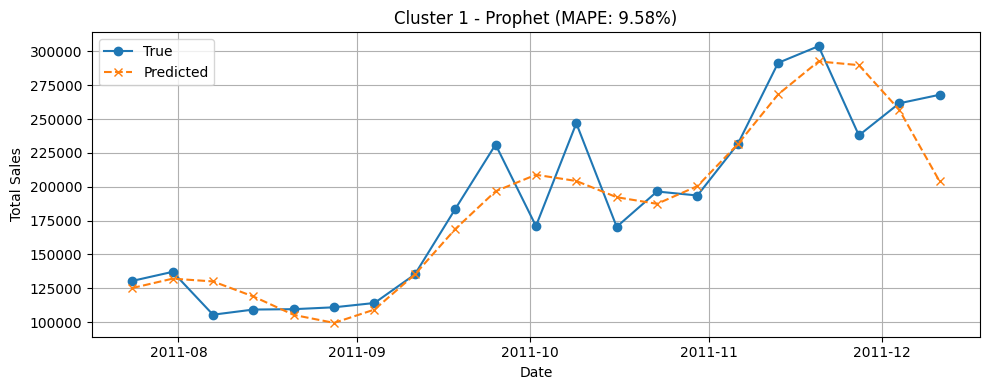


⏳ Tuning Prophet for Cluster 2


100%|██████████| 128/128 [01:23<00:00,  1.52it/s]


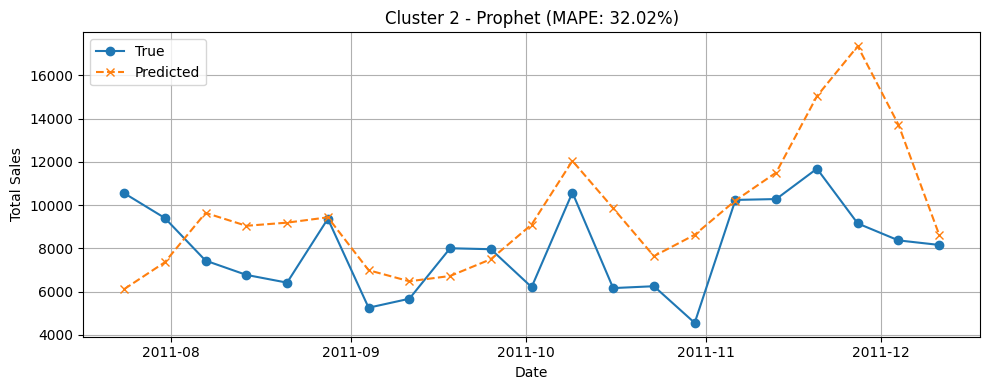


📊 Cluster-wise Forecasting MAPE (Prophet):
    MAPE (%)
0   9.581276
1  32.021185

🌍 Total MAPE (Prophet): 20.80%

✅ Best params for Cluster 1:
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_fourier': 7, 'weekly_fourier': 10, 'monthly_fourier': 5, 'use_holidays': True, 'add_weekly': True, 'add_monthly': False}

✅ Best params for Cluster 2:
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_fourier': 10, 'weekly_fourier': 10, 'monthly_fourier': 5, 'use_holidays': False, 'add_weekly': True, 'add_monthly': True}

🔍 Analyzing error for Cluster 1
Cluster 1 - Period 1 MAPE: 8.35%
Cluster 1 - Period 2 MAPE: 11.42%
Cluster 1 - Period 3 MAPE: 8.98%

🔍 Analyzing error for Cluster 2
Cluster 2 - Period 1 MAPE: 29.16%
Cluster 2 - Period 2 MAPE: 25.54%
Cluster 2 - Period 3 MAPE: 41.37%


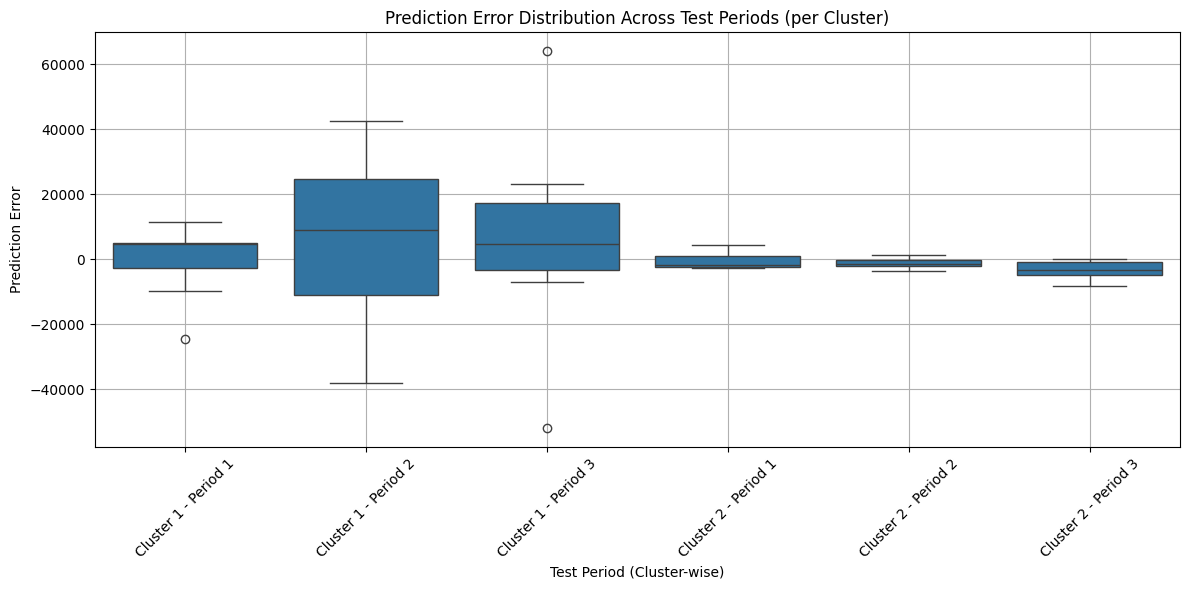


Drawing overall flattened forecast trend and test period error analysis...

Total MAPE (Prophet, Flattened): 20.80%


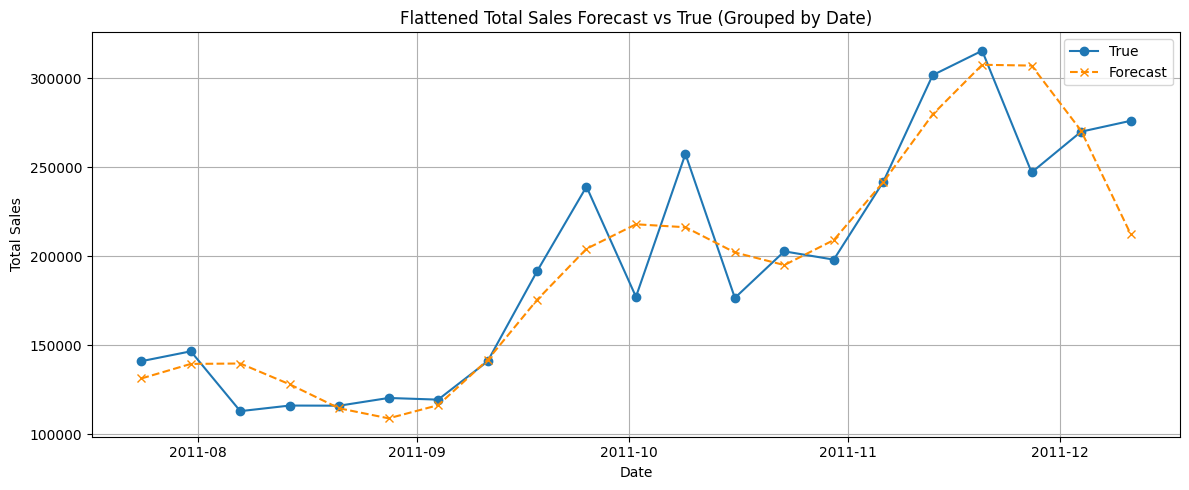

Period 1 MAPE: 18.75%
Period 2 MAPE: 18.48%
Period 3 MAPE: 25.18%


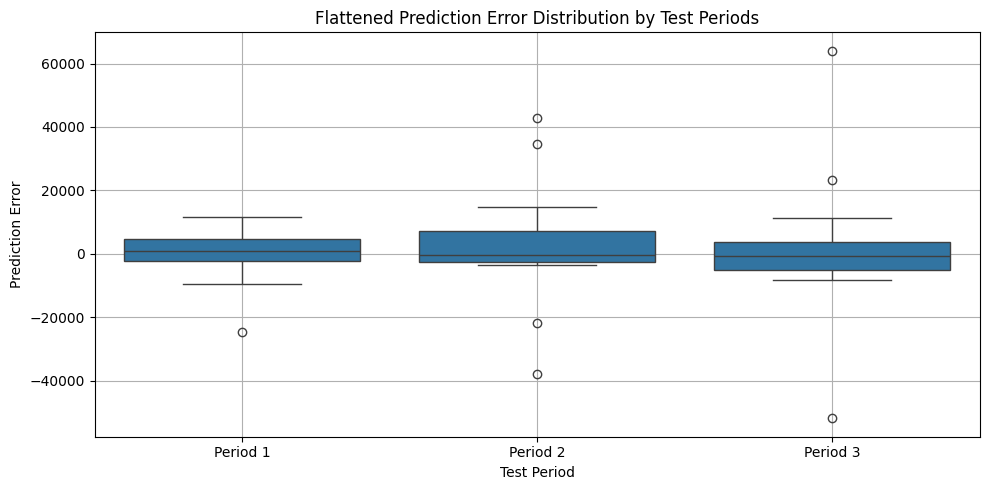

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import seaborn as sns

# Step 1: Load data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

product_clusters = pd.read_csv("Our Categorization/product_cluster_labels_a2.csv", index_col=0)

weekly_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 2: Train / test split
split_date = weekly_sales.index[int(len(weekly_sales) * 0.8)]
train_sales = weekly_sales.loc[:split_date]
test_sales = weekly_sales.loc[split_date:]

# Step 3: KNN for unknown products
known_products = product_clusters.index
unknown_products = [p for p in test_sales.columns if p not in known_products]

scaler = StandardScaler()
X_known = scaler.fit_transform(train_sales[known_products].T)
y_known = product_clusters.loc[known_products]["cluster"]

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_known, y_known)

if unknown_products:
    X_unknown = scaler.transform(test_sales[unknown_products].T)
    predicted_clusters = knn.predict(X_unknown)
    predicted_df = pd.DataFrame({"StockCode": unknown_products, "cluster": predicted_clusters}).set_index("StockCode")
    all_clusters = pd.concat([product_clusters, predicted_df])
else:
    all_clusters = product_clusters.copy()

# Step 4: Aggregate by cluster
train_cluster_series = train_sales.T.join(all_clusters).groupby("cluster").sum().T
test_cluster_series = test_sales.T.join(all_clusters).groupby("cluster").sum().T

# Step 5: Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1],
    'seasonality_prior_scale': [0.1, 1.0],
    'holidays_prior_scale': [0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_fourier': [5, 6, 7, 8, 9, 10],
    'weekly_fourier': [5,10],
    'monthly_fourier': [5,10],
    'use_holidays': [True, False],
    'add_weekly': [True, False],
    'add_monthly': [True, False],
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# UK holidays
min_year = df.index.min().year
max_year = df.index.max().year
uk_holidays = make_holidays_df(year_list=list(range(min_year, max_year + 1)), country='UK')

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

# Step 6: Tuning function per cluster
def tune_one_config(train_df, test_df, param_values):
    params = dict(zip(param_names, param_values))
    try:
        if params['use_holidays']:
            m = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                seasonality_mode=params['seasonality_mode'],
                holidays=uk_holidays
            )
        else:
            m = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                seasonality_mode=params['seasonality_mode']
            )

        m.add_seasonality(name='yearly', period=365.25, fourier_order=params['yearly_fourier'])
        if params['add_weekly']:
            m.add_seasonality(name='weekly', period=7, fourier_order=params['weekly_fourier'])
        if params['add_monthly']:
            m.add_seasonality(name='monthly', period=30.5, fourier_order=params['monthly_fourier'])

        m.fit(train_df)
        future = m.make_future_dataframe(periods=len(test_df), freq="W")
        forecast = m.predict(future)
        y_pred = forecast.iloc[-len(test_df):]["yhat"].values
        score = mape(test_df["y"].values, y_pred)

        return (score, m, forecast, params)
    except Exception as e:
        return None

# Step 7: Run tuning per cluster
results = {}

for cluster_id in train_cluster_series.columns:
    print(f"\n⏳ Tuning Prophet for Cluster {cluster_id + 1}")
    full_series = pd.concat([train_cluster_series[cluster_id], test_cluster_series[cluster_id]])
    full_df = pd.DataFrame({"ds": full_series.index, "y": full_series.values}).reset_index(drop=True)
    train_len = len(train_cluster_series)
    train_df = full_df.iloc[:train_len]
    test_df = full_df.iloc[train_len:]

    best_mape = float("inf")
    best_model = None
    best_forecast = None
    best_params = None

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(tune_one_config, train_df, test_df, params) for params in param_combinations]
        for future in tqdm(futures):
            result = future.result()
            if result and result[0] < best_mape:
                best_mape, best_model, best_forecast, best_params = result

    y_true = test_df["y"].values
    y_pred = best_forecast.iloc[-len(test_df):]["yhat"].values
    test_dates = test_df["ds"].values

    results[cluster_id] = {
        "model": best_model,
        "mape": best_mape,
        "true": y_true,
        "pred": y_pred,
        "dates": test_dates,
        "best_params": best_params
    }

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_true, label="True", marker='o')
    plt.plot(test_dates, y_pred, label="Predicted", linestyle='--', marker='x')
    plt.title(f"Cluster {cluster_id+1} - Prophet (MAPE: {best_mape:.2f}%)")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 8: Summary
mape_summary = pd.DataFrame({k: v["mape"] for k, v in results.items()}, index=["MAPE (%)"]).T
print("\n📊 Cluster-wise Forecasting MAPE (Prophet):")
print(mape_summary)

# Step 9: Global MAPE
all_y_true = []
all_y_pred = []

for result in results.values():
    all_y_true.extend(result["true"])
    all_y_pred.extend(result["pred"])

global_mape = mape(np.array(all_y_true), np.array(all_y_pred))
print(f"\n🌍 Total MAPE (Prophet): {global_mape:.2f}%")

# Step 10: Print best params
for cid, res in results.items():
    print(f"\n✅ Best params for Cluster {cid + 1}:")
    print(res["best_params"])

# Step 11: Error analysis: split test into 3 parts and plot errors
cluster_errors = []

for cid, res in results.items():
    print(f"\n🔍 Analyzing error for Cluster {cid + 1}")

    dates = res["dates"]
    y_true = res["true"]
    y_pred = res["pred"]

    split_dates = np.array_split(dates, 3)

    for i, split in enumerate(split_dates):
        idx = np.isin(dates, split)
        errors = y_true[idx] - y_pred[idx]

        cluster_errors.append(
            pd.DataFrame({
                "Error": errors,
                "Test Period": f"Cluster {cid+1} - Period {i+1}"
            })
        )

        period_mape = mape(y_true[idx], y_pred[idx])
        print(f"Cluster {cid+1} - Period {i+1} MAPE: {period_mape:.2f}%")

error_df = pd.concat(cluster_errors)

plt.figure(figsize=(12, 6))
sns.boxplot(x="Test Period", y="Error", data=error_df)
plt.title("Prediction Error Distribution Across Test Periods (per Cluster)")
plt.xticks(rotation=45)
plt.xlabel("Test Period (Cluster-wise)")
plt.ylabel("Prediction Error")
plt.grid()
plt.tight_layout()
plt.show()

# Step 12: Overall trend and test period error (flattened, sorted by date before qcut)

print("\nDrawing overall flattened forecast trend and test period error analysis...")

# Step 12-1: Flatten all predictions from all clusters
all_y_true = []
all_y_pred = []
all_dates = []

for res in results.values():
    all_y_true.extend(res["true"])
    all_y_pred.extend(res["pred"])
    all_dates.extend(res["dates"])

flat_df = pd.DataFrame({
    "ds": all_dates,
    "true": all_y_true,
    "pred": all_y_pred
})

# Step 12-2: Sort by time to ensure correct period assignment
flat_df = flat_df.sort_values("ds").reset_index(drop=True)
flat_df["error"] = flat_df["true"] - flat_df["pred"]
flat_df["period"] = pd.qcut(flat_df.index, 3, labels=["Period 1", "Period 2", "Period 3"])

# Step 12-3: Print total MAPE
flat_mape = mape(flat_df["true"], flat_df["pred"])
print(f"\nTotal MAPE (Prophet, Flattened): {flat_mape:.2f}%")

# Step 12-4: Group by date for clean trend plot
aggregated_df = flat_df.groupby("ds")[["true", "pred"]].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(aggregated_df["ds"], aggregated_df["true"], label="True", marker='o', linestyle='-', color='tab:blue')
plt.plot(aggregated_df["ds"], aggregated_df["pred"], label="Forecast", marker='x', linestyle='--', color='darkorange')
plt.title("Flattened Total Sales Forecast vs True (Grouped by Date)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 12-5: Three-period MAPE breakdown
for period in flat_df["period"].unique():
    subset = flat_df[flat_df["period"] == period]
    period_mape = mape(subset["true"], subset["pred"])
    print(f"{period} MAPE: {period_mape:.2f}%")

# Step 12-6: Boxplot of prediction error by period
plt.figure(figsize=(10, 5))
sns.boxplot(x="period", y="error", data=flat_df)
plt.title("Flattened Prediction Error Distribution by Test Periods")
plt.xlabel("Test Period")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()
